In [11]:
# librairies
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_score, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier, BallTree
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from IPython.display import display
from numpy import concatenate
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.io as sp
import pandas as pd



In [12]:
#traitement fichier.mat
dataset=sp.loadmat('breastw.mat')
X = dataset['X']
y = dataset['y']
#fin traitement mat

#Variables pour test
liste_distances = ['euclidean', 'l1', 'l2', 'manhattan', 'matching', 'minkowski', 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'dice', 'infinity', 'p']
#NE MARCHE PAS : 'pyfunc', 'seuclidean', 'wminkowski'
#marche mais trop d'info : 'jaccard', 'kulsinski', 'hamming', 'rogerstanimoto', 'russellrao',  'sokalmichener', 'sokalsneath' , 
n_voisins = range(1,80,5) #nombre de voisins

#print(sorted(BallTree.valid_metrics))
#Fin variables
"""
i=1
#MC=np.zeros((48,4))

def create(row, col):
    return [[[]for _ in range(col)]  for _ in range(row)]

KN = range(1, 51, 3)
MC = create(2*len(KN)*4+1,4)
MC[0][0]='k (nb voisins)'
MC[0][1]='w (poids)'
MC[0][2]='a (algorithme))'
MC[0][3]='AUC'
"""

"\ni=1\n#MC=np.zeros((48,4))\n\ndef create(row, col):\n    return [[[]for _ in range(col)]  for _ in range(row)]\n\nKN = range(1, 51, 3)\nMC = create(2*len(KN)*4+1,4)\nMC[0][0]='k (nb voisins)'\nMC[0][1]='w (poids)'\nMC[0][2]='a (algorithme))'\nMC[0][3]='AUC'\n"

In [13]:
skf = StratifiedKFold(n_splits=10,shuffle=True) # équilibrage dataset

for train_index, test_index in skf.split(X,y):
    
    test =False
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    y_train=np.ravel(y_train)
    y_test=np.ravel(y_test)

    test =False
    #for k in range(1,50,5) :
    for k in range(1,len(X_test),5) :
        for distance in liste_distances :
            #algo knn
            model_KNN = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', metric=distance)
            model_KNN.fit(X_train,y_train)
            y_pred_KNN = model_KNN.predict(X_test)
            
            model_PCA = PCA(n_components=2)
            data_reduced = model_PCA.fit_transform(X_test)
            #fin algo knn
            y_scores_KNN = model_KNN.predict_proba(X_test)
            y_scores_KNN = y_scores_KNN[:, 1]
            
            F1_KNN = round(f1_score(y_test,y_pred_KNN),3)
            recall_KNN = round(recall_score(y_test,y_pred_KNN),3)
            precision_KNN = round(precision_score(y_test,y_pred_KNN,zero_division=0),3)
            accuracy_KNN = round(accuracy_score(y_test,y_pred_KNN),3)
            AUC_KNN = round(roc_auc_score(y_test, y_scores_KNN),3)
            
            if test == False :
                matrice_KNN = np.array([[k,distance,F1_KNN,recall_KNN,precision_KNN,accuracy_KNN,AUC_KNN]])
                test = True
            else :
                matrice_KNN = np.append(matrice_KNN,np.array([k,distance,F1_KNN,recall_KNN,precision_KNN,accuracy_KNN,AUC_KNN]).reshape(1,7),axis=0)

df_KNN=pd.DataFrame(matrice_KNN,  columns=['Nombre_voisins', 'Distance','F1 score','Recall','Precision','Accuracy','AUC'])
df_KNN = df_KNN.astype({'F1 score': float, 'Recall': float,'Precision': float,'Accuracy': float,'AUC': float})
filtered_values_1 = np.where((df_KNN['F1 score']>=0.93) & (df_KNN['Recall']>=0.925) & (df_KNN['Precision']>=0.925) & (df_KNN['AUC']>=0.925))
display(df_KNN.iloc[filtered_values_1].sort_values(by=['AUC'], ascending=False))

df_KNN.to_csv("Dataset comparaison param KNN.csv")

,Nombre_voisins,Distance,F1 score,Recall,Precision,Accuracy,AUC


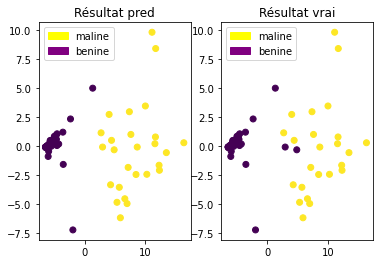

In [16]:
plt.subplot(1, 2, 1)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_pred_KNN)
plt.title("Résultat pred")
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

plt.subplot(1, 2, 2)
plt.scatter(data_reduced[:,0],data_reduced[:,1],c=y_test)
plt.title("Résultat vrai")
maline = mpatches.Patch(color='yellow', label='maline')
benine = mpatches.Patch(color='purple', label='benine')
plt.legend(handles=[maline,benine])

plt.show()

[0.65549993 0.08621632]
0.7417162482831758


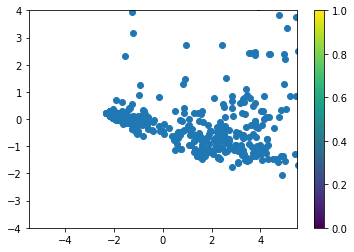

In [15]:
#X = dataset.values

X_scaled = StandardScaler().fit_transform(dataset['X'])

pca = decomposition.PCA(n_components=2)
pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'Rank'
    c=dataset.get('AUC'))

plt.xlim([-5.5, 5.5])
plt.ylim([-4, 4])
plt.colorbar()